<a href="https://colab.research.google.com/github/hmehryar/Hm.JetscapeMl/blob/ml5/jet-ml-pointnet/jet_ml_pointnet_classifier_all_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)# Point cloud classification with PointNet for Heavy Ion Collisions for diffrent dataset size and K-Folding

**Authors:** [Haydar Mehryar](https://github.com/hmehryar) <br>
**Date created:** 2023/12/01<br>
**Last modified:** 2020/12/20<br>
**Description:** Implementation of PointNet for heavy ion colllisions classifiction, based on the code from [David Griffiths](https://dgriffiths3.github.io)

In [25]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.source')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

If using colab first install trimesh with `!pip install trimesh`.


In [26]:
pip install --upgrade keras tensorflow

  Using cached keras-3.0.2-py3-none-any.whl (1.0 MB)
  Using cached namex-0.0.7-py3-none-any.whl (5.8 kB)


In [27]:
# loading libraries
print('Loading/Installing Package => Begin\n\n')
import jet_ml_dataset_builder.jet_ml_dataset_builder_utilities as util
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import set_directory_paths
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import parse_parameters
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import load_dataset
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import install
install("trimesh")
import os
from time import time
import glob
import trimesh
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, History
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import json


tf.random.set_seed(1234)
print('\nLoading/Installing Package => End\n\n')


Loading/Installing Package => Begin


Installing trimesh
Installed trimesh


Loading/Installing Package => End




In [28]:


print('\n########################################################################')
print('Checking the running platforms\n')

# Call the function and retrieve the dataset_directory_path and simulation_directory_path
dataset_directory_path, simulation_directory_path = set_directory_paths()

# Access the dataset_directory_path and simulation_directory_path
print("Dataset Directory Path:", dataset_directory_path)
print("Simulation Directory Path:", simulation_directory_path)
print('########################################################################\n')





########################################################################
Checking the running platforms

Python version: 3.10.12
OS: Linux
OS version: 6.1.58+
running on Colab: True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Directory Path: /content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.data/
Simulation Results Path: /content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/
Dataset Directory Path: /content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.data/
Simulation Directory Path: /content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/
########################################################################



In [29]:


# Call the function and retrieve the tokenized parameters
tokenized_arguments, tokenized_values = parse_parameters()

# Access the tokenized arguments and values
print("Tokenized Arguments:")
for argument in tokenized_arguments:
    print(argument)

print("\nTokenized Values:")
for argument, value in tokenized_values.items():
    print(f"{argument}: {value}")

y_class_label_items=['MMAT','MLBT']
alpha_s_items=[0.2 ,0.3 ,0.4]
q0_items=[1.5 ,2.0 ,2.5]

print("y_class_label_items:",y_class_label_items)
print("alpha_s_items:",alpha_s_items)
print("q0_items:",q0_items)

option -f not recognized
Tokenized Arguments:

Tokenized Values:
y_class_label_items: ['MMAT', 'MLBT']
alpha_s_items: [0.2, 0.3, 0.4]
q0_items: [1.5, 2.0, 2.5]


In [30]:
print("Building required params for the loading the dataset file")

class_labels_str = '_'.join(y_class_label_items)
alpha_s_items_str='_'.join(map(str, alpha_s_items))
q0_items_str='_'.join(map(str, q0_items))
total_size=9*1200000
# for shuffled_y_processed
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{total_size}_split_train_datasets/train_split_0.pkl"
# for shuffled
dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{1000}_shuffled.pkl"
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{10000}_shuffled.pkl"
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{100000}_shuffled.pkl"
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{1000000}_shuffled.pkl"
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{total_size}_shuffled.pkl"
simulation_directory_path='/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/'
dataset_file_name=simulation_directory_path+dataset_file_name
print("dataset_file_name:",dataset_file_name)

Building required params for the loading the dataset file
dataset_file_name: /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl


In [31]:
# loading dataset by size and getting just the first column
# Function to load datasets of different sizes
def get_dataset(size):
    dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{size}_shuffled.pkl"

    dataset_file_name=simulation_directory_path+dataset_file_name
    print("dataset_file_name:",dataset_file_name)

    dataset=load_dataset(dataset_file_name,has_test=False)
    (dataset_x, dataset_y) = dataset
    print('Extract the first column for binary classification')
    dataset_y = dataset_y[:, 0]
    print("dataset.x:",type(dataset_x), dataset_x.size, dataset_x.shape)
    print("dataset.y:",type(dataset_y), dataset_y.size,dataset_y.shape)
    return dataset_x, dataset_y

Building and Compiling the Classifier model

In [32]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {'num_features': self.num_features, 'l2reg': self.l2reg}

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

def build_pointnet_binary_classifier_model(NUM_POINTS,NUM_CLASSES):
    inputs = keras.Input(shape=(NUM_POINTS, 3))
    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    # outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    return model

In [33]:

# NUM_POINTS = 2048
NUM_POINTS = 1024
# NUM_CLASSES = 10
NUM_CLASSES = 2

pointnet=build_pointnet_binary_classifier_model(NUM_POINTS,NUM_CLASSES)
learning_rate=0.001

In [34]:
def compile_pointnet_binary_classifier_model_with_hyperparam(model,learning_rate):
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(
      # loss="sparse_categorical_crossentropy",
      loss="binary_crossentropy",
      optimizer=optimizer,
      # metrics=["sparse_categorical_accuracy"],
      metrics=["accuracy"],
  )
  model.summary()
  return model

In [35]:
pointnet=compile_pointnet_binary_classifier_model_with_hyperparam(pointnet,learning_rate)

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1024, 3)]            0         []                            
                                                                                                  
 conv1d_11 (Conv1D)          (None, 1024, 32)             128       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_17 (Ba  (None, 1024, 32)             128       ['conv1d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_17 (Activation)  (None, 1024, 32)             0         ['batch_normalization_1

In [36]:
# Classifiers
classifiers = {
    'Pointnet': pointnet,
}

In [37]:
def get_coordinates(image_array):
  import numpy as np
  # Get the dimensions of the original array
  height, width = image_array.shape
  # Create an array of coordinates (x, y)
  coordinates = np.column_stack((np.repeat(np.arange(height), width),
                                np.tile(np.arange(width), height)))
  return coordinates
def get_point_clouds(image_array,coordinates):
  # Assuming image_array is your 32x32 numpy array
  # image_array = np.random.randint(0, 256, (32, 32), dtype=np.uint8)
  # Create an nx3 array with x, y, and intensity values
  result_array = np.column_stack((coordinates, image_array.flatten()))
  return result_array

In [38]:
import numpy as np

def get_dataset_points(dataset_x):
    """
    Get 3D points for each entry in the dataset.

    Parameters:
    - dataset: 3D array-like, the dataset containing non-zero values.

    Returns:
    - dataset_points: NumPy array, each entry corresponds to the 3D points of non-zero values for a particular entry in the dataset.

    """
    dataset_points = []
    coordinates=get_coordinates(dataset_x[0])


    for data in dataset_x:

        point_clouds=get_point_clouds(data,coordinates)
        # Append coordinates to the list
        dataset_points.append(point_clouds)

    # Convert the list of coordinates to a NumPy array
    dataset_points = np.array(dataset_points)
    return dataset_points





In [39]:
def split_dataset(dataset_x, dataset_x_points, dataset_y, test_size=0.2, random_state=None):
    """
    Split the dataset into training and testing sets.

    Parameters:
    - dataset_x: The input data (3D array).
    - dataset_x_points: The 3D coordinates corresponding to each entry.
    - dataset_y: The target values (2D array).
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed for random number generation.

    Returns:
    - x_train, x_test: The split input data for training and testing.
    - x_train_points, x_test_points: The split 3D coordinates for training and testing.
    - y_train, y_test: The split target values for training and testing.
    """
    # Flatten the input data to 2D
    flattened_dataset_x = dataset_x.reshape(dataset_x.shape[0], -1)

    # Split the dataset
    x_train, x_test, x_train_points, x_test_points, y_train, y_test = \
        train_test_split(flattened_dataset_x, dataset_x_points, dataset_y, test_size=test_size, random_state=random_state)

    # Reshape the input data back to 3D
    x_train = x_train.reshape(x_train.shape[0], dataset_x.shape[1], dataset_x.shape[2])
    x_test = x_test.reshape(x_test.shape[0], dataset_x.shape[1], dataset_x.shape[2])

    return x_train, x_test, x_train_points, x_test_points, y_train, y_test




In [40]:
def parse_dataset(x_train,x_test):
    train_labels = []
    test_labels = []
    i=0
    for f in x_train:

        train_labels.append(i)
        i=i+1
    for f in x_test:
        test_labels.append(i)
        i=i+1
    return (
        np.array(train_labels),
        np.array(test_labels),
    )

In [41]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [18]:
def evaluate_model(model, x_test, y_test):
    """
    Evaluate the performance of a trained model on test data.

    Parameters:
    - model: The trained deep neural model.
    - x_test: Test data, it shall be in the cloud points format, each entry contains 1024x3 data.
    - y_test: True labels.

    Returns:
    - accuracy: Accuracy of the model on the test data.
    - confusion_matrix: Confusion matrix for the predictions.
    """
    # Assuming model is your trained deep neural model
    y_pred = model.predict(x_test)
    y_pred_class = np.argmax(y_pred, axis=1)  # Extracting the class with the highest probability

    # Assuming y_true is a Nx2 array where each row contains the true class probabilities
    y_true_class = np.argmax(y_test, axis=1)  # Extracting the class with the highest true probability

    accuracy = accuracy_score(y_true_class, y_pred_class)
    print(f'Accuracy: {accuracy}')

    cm = confusion_matrix(y_true_class, y_pred_class)
    print(f'Confusion Matrix: {cm}')

    return accuracy, cm

# Example usage:
# accuracy, confusion_matrix = evaluate_model(trained_model, test_data, true_labels)


In [42]:


def preprocess_dataset(dataset_x, dataset_y):
  print("Pre-processing")

  # Example usage:
  dataset_x_points = get_dataset_points(dataset_x)
  print("dataset_x_points shape:", dataset_x_points.shape)
  x_train, x_test, x_train_points, x_test_points, y_train, y_test= \
    split_dataset(dataset_x, dataset_x_points, dataset_y, test_size=0.2, random_state=None)

  print("train_x:",type(x_train), x_train.size, x_train.shape)
  print("train_points:",type(x_train_points), x_train_points.size, x_train_points.shape)
  print("train_y:",type(y_train), y_train.size,y_train.shape)

  print("x_test:",type(x_test), x_test.size, x_test.shape)
  print("x_test_points:",type(x_test_points), x_test_points.size, x_test_points.shape)
  print("y_test:",type(y_test), y_test.size,y_test.shape)
  train_labels, test_labels = parse_dataset(x_train,x_test)
  print(train_labels.size,test_labels.size)


  train_dataset = tf.data.Dataset.from_tensor_slices((x_train_points, train_labels))
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test_points, test_labels))


  BATCH_SIZE = 32

  train_dataset = train_dataset.shuffle(len(x_train_points)).map(augment).batch(BATCH_SIZE)
  test_dataset = test_dataset.shuffle(len(x_test_points)).batch(BATCH_SIZE)

  # Preprocess y_train and y_test
  # One-hot encode the categorical variable
  # print(y_train)
  y_train_categorical = np.array(y_train).reshape(-1, 1)
  y_test_categorical = np.array(y_test).reshape(-1, 1)

  encoder = OneHotEncoder(sparse_output=False)
  y_train_categorical_encoded = encoder.fit_transform(y_train_categorical)
  y_test_categorical_encoded = encoder.transform(y_test_categorical)
  print(y_test_categorical[:10])
  print(y_test_categorical_encoded[:10])
  return (x_train_points,  y_train_categorical_encoded,x_test_points,  y_test_categorical_encoded)


In [43]:
def plot_training_history(history,simulation_path):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0, len(history.history['accuracy'])+1,5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0, len(history.history['accuracy'])+1,5))

    # Adjust layout and show the plot
    plt.tight_layout()


    # Save the plot with high resolution (300 dpi)
    file_name='_accuracy_loss.png'
    file_path=simulation_path+file_name
    plt.savefig(file_path, dpi=300)
    plt.show()
    plt.close()
    return file_path

# Plot the training history
# plot_training_history_path=plot_training_history(history,simulation_path)

In [44]:

def save_training_history(history,simulation_path):
  # Save the training history to a file (e.g., JSON format)

  training_history_file_path =simulation_path+'_training_history'
  # training_history_file_path  =simulation_directory_path+training_history_file_name

  training_history_file_path_json=training_history_file_path+'.json'
  with open(training_history_file_path_json, 'w') as f:
      json.dump(history.history, f)
  print(training_history_file_path_json)

  training_history_file_path_csv=training_history_file_path+'.csv'
  pd.DataFrame.from_dict(history.history).to_csv(training_history_file_path_csv,index=False)
  print(training_history_file_path_csv)

  training_history_file_path_npy=training_history_file_path+'.npy'
  np.save(training_history_file_path_npy,history.history)
  print(training_history_file_path_npy)
  return training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv

# training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
#   save_training_history(history,simulation_path)

In [45]:
from sklearn.model_selection import KFold

# Function to train and evaluate classifiers
# This method shall get the cloud points as the trainset, to be trained by pointnet
def train_and_evaluate_classifier_kfold(model, x_train,y_train , x_test, y_test, n_epochs, monitor, k_folds,simulation_path):

    # Use KFold for k-fold cross-validation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    accuracies = []
    cms = []
    train_times = []
    all_histories = []  # Store histories for each fold
    plots=[]
    models=[]
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train)):
    # train_index, val_index in kfold.split(x_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Include both ModelCheckpoint and History callbacks in the callbacks list
        # callbacks=[checkpoint_callback]
        fold_path=f'{simulation_path}_fold_{fold}'
        # Use ModelCheckpoint callback to save the best model
        best_model_file_path = f'{fold_path}_best_model.keras'
        models.append(best_model_file_path)
        checkpoint_callback = ModelCheckpoint(
            best_model_file_path,
            monitor=monitor,
            save_best_only=True,
            mode="max" if monitor == "val_accuracy" else "min",
            verbose=1
        )

        # Use History callback to retrieve the training history
        history_callback = History()

        start = time()
        history = model.fit(
            x_train_fold,
            y_train_fold,
            epochs=n_epochs,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[checkpoint_callback]
        )
        train_time = (time()-start)/60.0
        train_times.append(train_time)
        # Append history to the list
        all_histories.append(history.history)

        plot=plot_training_history(history,fold_path)
        training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
         save_training_history(history,fold_path)
        plots.append(plot)

        accuracy, confusion_matrix = evaluate_model(model, x_test, y_test)
        accuracies.append(accuracy)
        cms.append(confusion_matrix)

    return accuracies, cms, train_times, all_histories, plots,models

In [ ]:
monitor = 'val_accuracy'  # 'val_accuracy' or 'val_loss'
n_epochs = 20
k_folds = 2  # You can adjust the number of folds

print(simulation_directory_path)
current_simulation_name=f'jetml_pointnet_classification_eloss_{class_labels_str}_size_{1000}'
current_simulation_path=simulation_directory_path+current_simulation_name
print(current_simulation_path)

(dataset_x, dataset_y)= get_dataset(1000)
(x_train,  y_train,x_test,  y_test)=preprocess_dataset(dataset_x, dataset_y)

Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 2.4498 - accuracy: 0.5125
Epoch 1: val_accuracy improved from -inf to 0.56500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_0_best_model.keras
13/13 [==============================] - 23s 307ms/step - loss: 2.4498 - accuracy: 0.5125 - val_loss: 1.8981 - val_accuracy: 0.5650
Epoch 2/20
12/13 [==========================>...] - ETA: 0s - loss: 1.9314 - accuracy: 0.5755
Epoch 2: val_accuracy did not improve from 0.56500
13/13 [==============================] - 1s 92ms/step - loss: 1.9115 - accuracy: 0.5650 - val_loss: 1.8572 - val_accuracy: 0.5475
Epoch 3/20
12/13 [==========================>...] - ETA: 0s - loss: 1.8969 - accuracy: 0.5781
Epoch 3: val_accuracy did not improve from 0.56500
13/13 [==============================] - 1s 100ms/step - loss: 1.8703 - accuracy: 0.5850 - val_loss: 1.9475 - val_accura

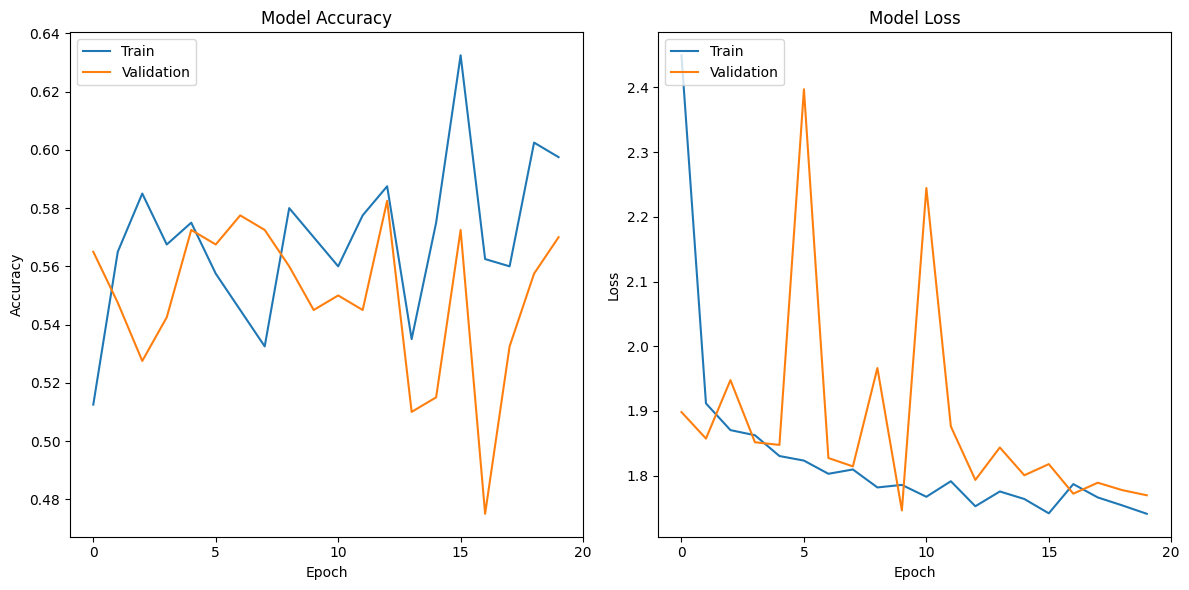

/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_0_training_history.json
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_0_training_history.csv
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_0_training_history.npy
Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 1.7496 - accuracy: 0.5925
Epoch 1: val_accuracy improved from -inf to 0.61000, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_1_best_model.keras
13/13 [==============================] - 3s 203ms/step - loss: 1.7496 - accuracy: 0.5925 - val_loss: 1.7783 - val_accuracy: 0.6100
Epoch 2/20
12/13 [===============

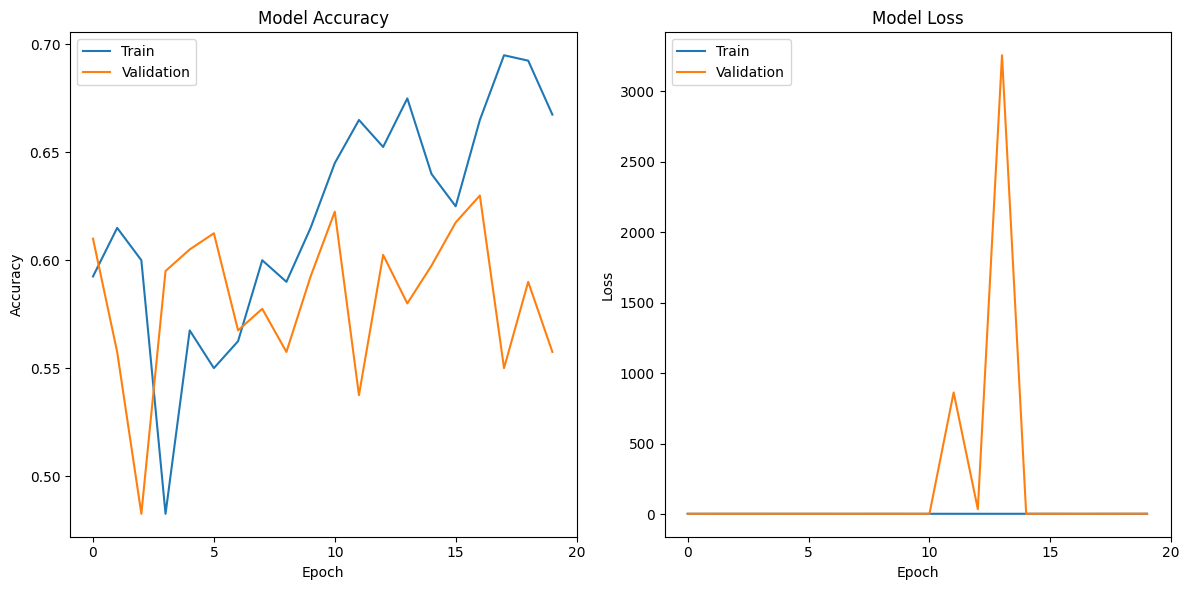

/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_1_training_history.json
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_1_training_history.csv
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_1_training_history.npy
Accuracies: [0.54, 0.67]
Confusion Matrices: [array([[52, 36],
       [56, 56]]), array([[ 23,  65],
       [  1, 111]])]
Train Times: [0.8034488320350647, 0.6837429245313008]
Plot Paths: ['/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_0_accuracy_loss.png', '/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_si

In [24]:
#example for testing classifier k fold training
accuracies, cms, train_times, all_histories, plots,models = \
    train_and_evaluate_classifier_kfold(pointnet, x_train,  y_train,x_test,  y_test, n_epochs, monitor, k_folds,current_simulation_path)

print(f'Accuracies: {accuracies}')
print(f'Confusion Matrices: {cms}')
print(f'Train Times: {train_times} minutes')
print(f'Plot Paths: {plots}')
print(f'Model Paths: {plots}')
# Calculate average accuracy and confusion matrix
avg_accuracy = np.mean(accuracies)
avg_cm = np.mean(cms, axis=0)

print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Confusion Matrix: {avg_cm}')
print(f'Average Train Time: {np.mean(train_times)} minutes')

print(f'Histories:{all_histories}')

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Load the DataFrame from the saved file
#df_results = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/binary_classification_results_kfold_errorbar.txt", sep='\t')

def plot_save_mean_error_bar(df_results,simulation_path):
    # df_results= df_results_kfold_errorbar
    print(df_results)
    # Set a seaborn style (optional)
    sns.set(style="whitegrid")


    # Define a dictionary to map classifiers to markers
    marker_dict = {
        'Pointnet': 'o',
        # 'Decision Tree': 's',
        # 'LinearSVC': '^',
        # 'KNN': 'v',
        # 'Random Forest': 'D'
    }
    plt.figure(figsize=(10, 6))

    for clf_name, group in df_results.groupby('Classifier'):
        plt.errorbar(
            group['Dataset_Size'],
            group['Mean_Accuracy'],
            yerr=group['Std_Accuracy'],
            label=clf_name,
            marker=marker_dict.get(clf_name, 'o'),  # Use 'o' as default marker if not found in the dictionary
            capsize=5
        )

    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlabel('Dataset Size (log scale)')
    plt.ylabel('Mean Accuracy')
    plt.title('Binary Classification Accuracy with Error Bars for Different Dataset Sizes')
    plt.legend()
    # plt.grid(True)
    # Save the plot with high resolution (300 dpi)
    accuracy_errorbar_plot_path=simulation_path+'_accuracy_errorbar_plot.png'
    plt.savefig(accuracy_errorbar_plot_path, dpi=300)
    plt.show()

In [48]:

def train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds):
  print(simulation_path)

  # Results storage
  results_kfold = []
  results_kfold_errorbar=[]
  # Loop through different dataset sizes
  for size in dataset_sizes:
      current_simulation_name=f'_size_{size}'
      current_simulation_path=simulation_path+current_simulation_name
      print(current_simulation_path)
      # Generate dataset
      # x, y = get_dataset(size)
      (dataset_x, dataset_y)= get_dataset(size)
      (x_train,  y_train,x_test,  y_test)=preprocess_dataset(dataset_x, dataset_y)

      # Loop through classifiers
      for clf_name, clf in classifiers.items():

          # Evaluate classifier using k-fold cross-validation
          fold_accuracies, fold_conf_matrices, fold_train_times, all_histories, plots, models = \
          train_and_evaluate_classifier_kfold(pointnet, x_train,  y_train,x_test,  y_test, n_epochs, monitor, k_folds,current_simulation_path)
          # fold_accuracies, fold_conf_matrices, fold_train_times, all_histories = \
          # train_and_evaluate_classifier_kfold(clf, x_train,y_train, x_test, y_test, n_epochs, monitor, k_folds)
          # fold_scores, fold_conf_matrices = train_and_evaluate_classifier_kfold(clf, x, y)

          # Store results for each fold
          for fold_num, (accuracy, cm,train_time,plot,model) in enumerate(zip(fold_accuracies, fold_conf_matrices,fold_train_times,plots,models), start=1):
              results_kfold.append({
                  'Dataset Size': size,
                  'Classifier': clf_name,
                  'Fold Number': fold_num,
                  'Accuracy': accuracy,
                  'Confusion Matrix': cm,
                  'Train Time': train_time,
                  'Loss/Accuracy Plot Path': plot,
                  'Best Model Path': model
              })
          print(f'Average Train Time: {np.mean(train_times)} minutes')
          # Calculate mean and standard deviation of accuracy scores
          mean_accuracy = np.mean(fold_accuracies)
          std_accuracy = np.std(fold_accuracies)

          # Store results
          results_kfold_errorbar.append({
              'Dataset_Size': size,
              'Classifier': clf_name,
              'Mean_Accuracy': mean_accuracy,
              'Std_Accuracy': std_accuracy
          })
  # Create a DataFrame from k-fold results
  df_results_kfold = pd.DataFrame(results_kfold)
  # Save the DataFrame to a text file
  results_kfold_path=simulation_path+'_results_kfold.txt'
  df_results_kfold.to_csv(results_kfold_path, index=False, sep='\t')
  # Display results in a table
  print(df_results_kfold)

  # Create a DataFrame from k-fold results
  df_results_kfold_errorbar = pd.DataFrame(results_kfold_errorbar)
  # Save the DataFrame to a text file
  results_kfold_errorbar_path=simulation_path+'_results_kfold_errorbar.txt'
  df_results_kfold_errorbar.to_csv(results_kfold_errorbar_path, index=False, sep='\t')
  # Display results in a table
  print(df_results_kfold_errorbar)
  plot_save_mean_error_bar(df_results_kfold_errorbar,simulation_path)

/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000
dataset_file_name: /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
Extract the first column for binary classification
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 1000 (1000,)
Pre-processing
dataset_x_points shape: (1000, 1024, 3)
train_x: <class 'numpy.ndarray'> 819200 (800, 32, 32)
train_points: <class 'numpy.ndarray'> 2457600 (800, 1024, 3)
trai

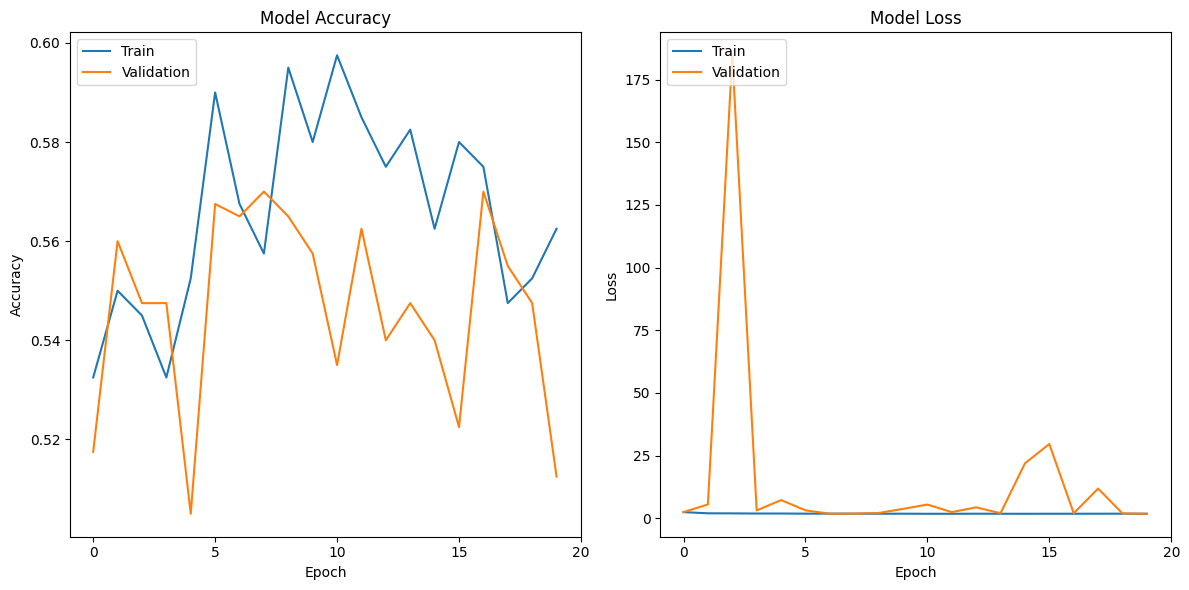

/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_0_training_history.json
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_0_training_history.csv
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_0_training_history.npy
7/7 [==============================] - 1s 20ms/step
Accuracy: 0.555
Confusion Matrix: [[47 55]
 [34 64]]
Epoch 1/20
12/13 [==========================>...] - ETA: 0s - loss: 1.7751 - accuracy: 0.5286
Epoch 1: val_accuracy improved from -inf to 0.58500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_1_best_model.keras
13/13 [==============================] - 2s 134ms/step - lo

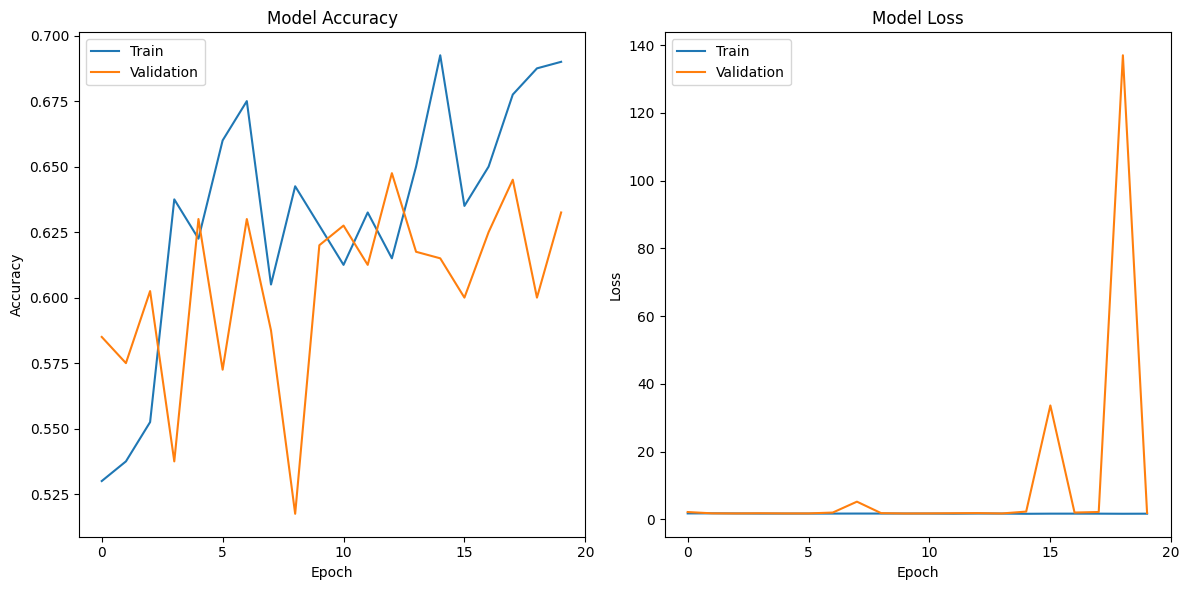

/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_1_training_history.json
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_1_training_history.csv
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_fold_1_training_history.npy
7/7 [==============================] - 0s 20ms/step
Accuracy: 0.625
Confusion Matrix: [[76 26]
 [49 49]]
Average Train Time: 0.7435958782831827 minutes
   Dataset Size Classifier  Fold Number  Accuracy      Confusion Matrix  \
0          1000   Pointnet            1     0.555  [[47, 55], [34, 64]]   
1          1000   Pointnet            2     0.625  [[76, 26], [49, 49]]   

   Train Time                            Loss/Accuracy Plot Path  \
0    0.938478  /content/drive/MyDrive/Projects

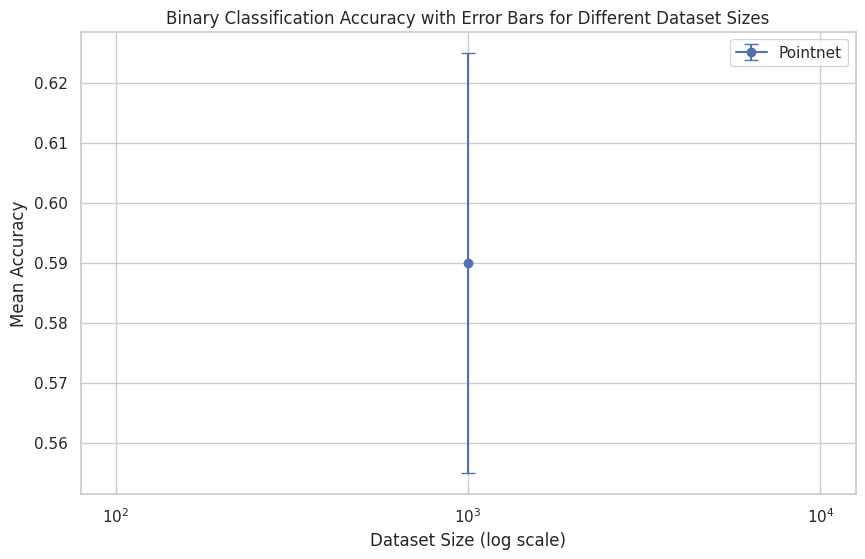

In [49]:
monitor = 'val_accuracy'  # 'val_accuracy' or 'val_loss'
n_epochs = 20
k_folds = 2  # You can adjust the number of folds

# defining dataset sizes and classifiers

# Sizes of datasets
dataset_sizes = [1000]
# dataset_sizes = [1000, 10000]
# dataset_sizes = [1000, 10000, 100000, 1000000]

print(simulation_directory_path)
simulation_path=f'{simulation_directory_path}jetml_pointnet_classification_eloss_{class_labels_str}'
train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds)